In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("H:\My Drive\iHARP\SIE Prediction\Arctic_domain_mean_1979_2018 - Curated.csv")

df['sea_ice_extent'] = df['sea_ice_extent']/10**6

# Some irregular values from 1/2/1988 to 1/12/1988

In [3]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)

In [4]:
df['day']  = df.index.day
df['week'] = df.index.week
df['month']  = df.index.month
#df['year'] = df.index.year

cols = ['day','week','month']
df = df[cols + [c for c in df.columns if c not in cols]]

C:\Users\FAHAD\AppData\Local\Temp/ipykernel_31716/2294910911.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


In [5]:
df.tail(len(df))

,day,week,month,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
Day,,,,,,,,,,,,,,
1979-01-01,1,1,1,5.872050,0.786595,184.999071,1.417925,1.089897,1.031549,33.341556,273.379711,250.401819,979.401142,14.585189
1979-01-02,2,1,1,6.155597,0.756973,182.686318,1.368594,0.923499,0.837877,33.341556,273.376830,250.364683,979.340886,14.997215
1979-01-03,3,1,1,5.691054,0.777598,186.387764,1.197913,1.218984,1.066028,33.341556,273.385489,250.452749,983.409060,14.997215
1979-01-04,4,1,1,5.628824,0.819629,191.888081,1.405106,1.783778,1.448627,33.341556,273.396461,250.290579,983.557055,14.922219
1979-01-05,5,1,1,6.255928,0.869896,190.541890,1.305893,0.995828,0.776768,33.341556,273.404602,250.895886,978.020927,14.922219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,27,52,12,5.700206,1.026874,195.631612,1.005868,1.047516,0.807935,33.437008,273.993458,253.176978,983.214961,12.324834
2018-12-28,28,52,12,5.960630,0.992543,195.926366,1.127954,1.188444,0.906977,33.437008,274.009713,252.957151,983.126983,12.343956
2018-12-29,29,52,12,5.778559,0.940292,197.973447,1.219972,1.276387,1.065541,33.437008,273.986577,253.040940,981.042709,12.523124


In [6]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + lead_time])
    return np.array(dataX), np.array(dataY)

In [7]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32') # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=30, lead_time=1)        # 30 days lead time
y = y[:,target_index]

In [8]:
#train_size = int(len(X) * 0.80)

intance_2014 = 12784 - 30 - 1

trainX = X[:intance_2014]
trainY = y[:intance_2014]
testX = X[intance_2014:]
testY = y[intance_2014:]

<function matplotlib.pyplot.show(close=None, block=None)>

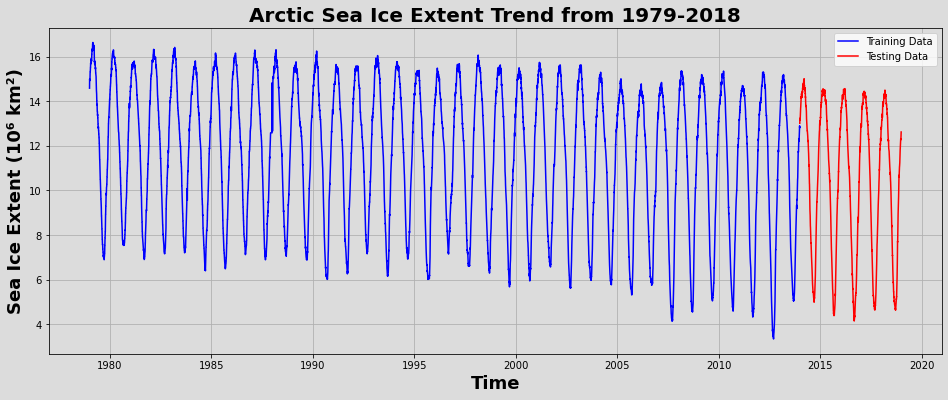

In [9]:
train_size = int(len(X) * 0.8)

plt.figure(figsize = (16,6), facecolor = '#dcdcdc')
ax = plt.axes()
ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 18,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 18,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(testY)], 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(testY):], 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

model = Sequential()
model.add(GRU(30, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(64 ,  activation = 'softmax'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 30)            4140      
                                                                 
 dropout (Dropout)           (None, 30, 30)            0         
                                                                 
 lstm (LSTM)                 (None, 256)               293888    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 314,541
Trainable params: 314,541
Non-trai

In [11]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
180/180 [==============================] - 45s 160ms/step - loss: 0.1211 - mae: 0.2921 - mse: 0.1211 - val_loss: 0.0783 - val_mae: 0.2419 - val_mse: 0.0783
Epoch 2/100
180/180 [==============================] - 25s 136ms/step - loss: 0.0557 - mae: 0.2062 - mse: 0.0557 - val_loss: 0.0873 - val_mae: 0.2456 - val_mse: 0.0873
Epoch 3/100
180/180 [==============================] - 25s 139ms/step - loss: 0.0552 - mae: 0.2040 - mse: 0.0552 - val_loss: 0.0882 - val_mae: 0.2460 - val_mse: 0.0882
Epoch 4/100
180/180 [==============================] - 25s 138ms/step - loss: 0.0552 - mae: 0.2036 - mse: 0.0552 - val_loss: 0.0877 - val_mae: 0.2458 - val_mse: 0.0877
Epoch 5/100
180/180 [==============================] - 25s 139ms/step - loss: 0.0552 - mae: 0.2038 - mse: 0.0552 - val_loss: 0.0884 - val_mae: 0.2461 - val_mse: 0.0884
Epoch 6/100
180/180 [==============================] - 25s 139ms/step - loss: 0.0552 - mae: 0.2038 - mse: 0.0552 - val_loss: 0.0886 - val_mae: 0.2463 - val_mse:

Epoch 24/100
180/180 [==============================] - 24s 131ms/step - loss: 4.2128e-04 - mae: 0.0162 - mse: 4.2128e-04 - val_loss: 8.7407e-04 - val_mae: 0.0202 - val_mse: 8.7407e-04
Epoch 25/100
180/180 [==============================] - 24s 132ms/step - loss: 4.0091e-04 - mae: 0.0157 - mse: 4.0091e-04 - val_loss: 6.7990e-04 - val_mae: 0.0168 - val_mse: 6.7990e-04
Epoch 26/100
180/180 [==============================] - 24s 132ms/step - loss: 3.7847e-04 - mae: 0.0152 - mse: 3.7847e-04 - val_loss: 7.7954e-04 - val_mae: 0.0200 - val_mse: 7.7954e-04
Epoch 27/100
180/180 [==============================] - 24s 132ms/step - loss: 3.4774e-04 - mae: 0.0146 - mse: 3.4774e-04 - val_loss: 5.6765e-04 - val_mae: 0.0152 - val_mse: 5.6765e-04
Epoch 28/100
180/180 [==============================] - 24s 133ms/step - loss: 3.4081e-04 - mae: 0.0145 - mse: 3.4081e-04 - val_loss: 6.1889e-04 - val_mae: 0.0165 - val_mse: 6.1889e-04
Epoch 29/100
180/180 [==============================] - 24s 132ms/step - lo

Epoch 46/100
180/180 [==============================] - 24s 132ms/step - loss: 1.9820e-04 - mae: 0.0110 - mse: 1.9820e-04 - val_loss: 3.1655e-04 - val_mae: 0.0125 - val_mse: 3.1655e-04
Epoch 47/100
180/180 [==============================] - 24s 131ms/step - loss: 2.0061e-04 - mae: 0.0111 - mse: 2.0061e-04 - val_loss: 2.7264e-04 - val_mae: 0.0114 - val_mse: 2.7264e-04
Epoch 48/100
180/180 [==============================] - 24s 132ms/step - loss: 1.9921e-04 - mae: 0.0111 - mse: 1.9921e-04 - val_loss: 3.1210e-04 - val_mae: 0.0123 - val_mse: 3.1210e-04
Epoch 49/100
180/180 [==============================] - 24s 133ms/step - loss: 1.9853e-04 - mae: 0.0110 - mse: 1.9853e-04 - val_loss: 2.7982e-04 - val_mae: 0.0117 - val_mse: 2.7982e-04
Epoch 50/100
180/180 [==============================] - 24s 132ms/step - loss: 2.0061e-04 - mae: 0.0111 - mse: 2.0061e-04 - val_loss: 4.1884e-04 - val_mae: 0.0153 - val_mse: 4.1884e-04
Epoch 51/100
180/180 [==============================] - 24s 131ms/step - lo

Epoch 68/100
180/180 [==============================] - 24s 131ms/step - loss: 1.5781e-04 - mae: 0.0098 - mse: 1.5781e-04 - val_loss: 2.4109e-04 - val_mae: 0.0109 - val_mse: 2.4109e-04
Epoch 69/100
180/180 [==============================] - 24s 131ms/step - loss: 1.6579e-04 - mae: 0.0101 - mse: 1.6579e-04 - val_loss: 2.8220e-04 - val_mae: 0.0114 - val_mse: 2.8220e-04
Epoch 70/100
180/180 [==============================] - 24s 131ms/step - loss: 1.5498e-04 - mae: 0.0097 - mse: 1.5498e-04 - val_loss: 2.1769e-04 - val_mae: 0.0100 - val_mse: 2.1769e-04
Epoch 71/100
180/180 [==============================] - 24s 131ms/step - loss: 1.5812e-04 - mae: 0.0098 - mse: 1.5812e-04 - val_loss: 2.1384e-04 - val_mae: 0.0101 - val_mse: 2.1384e-04
Epoch 72/100
180/180 [==============================] - 24s 133ms/step - loss: 1.5339e-04 - mae: 0.0097 - mse: 1.5339e-04 - val_loss: 3.6676e-04 - val_mae: 0.0152 - val_mse: 3.6676e-04
Epoch 73/100
180/180 [==============================] - 24s 133ms/step - lo

Epoch 90/100
180/180 [==============================] - 17s 96ms/step - loss: 1.2961e-04 - mae: 0.0089 - mse: 1.2961e-04 - val_loss: 2.0843e-04 - val_mae: 0.0098 - val_mse: 2.0843e-04
Epoch 91/100
180/180 [==============================] - 17s 96ms/step - loss: 1.3245e-04 - mae: 0.0090 - mse: 1.3245e-04 - val_loss: 1.8081e-04 - val_mae: 0.0087 - val_mse: 1.8081e-04
Epoch 92/100
180/180 [==============================] - 17s 97ms/step - loss: 1.2595e-04 - mae: 0.0087 - mse: 1.2595e-04 - val_loss: 2.0590e-04 - val_mae: 0.0098 - val_mse: 2.0590e-04
Epoch 93/100
180/180 [==============================] - 17s 97ms/step - loss: 1.2795e-04 - mae: 0.0088 - mse: 1.2795e-04 - val_loss: 2.8743e-04 - val_mae: 0.0126 - val_mse: 2.8743e-04
Epoch 94/100
180/180 [==============================] - 17s 95ms/step - loss: 1.3081e-04 - mae: 0.0089 - mse: 1.3081e-04 - val_loss: 1.9901e-04 - val_mae: 0.0095 - val_mse: 1.9901e-04
Epoch 95/100
180/180 [==============================] - 17s 96ms/step - loss: 1.

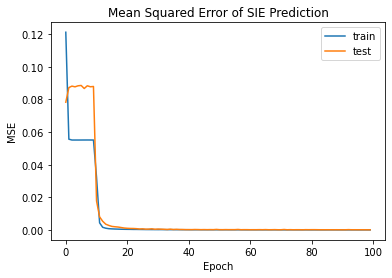

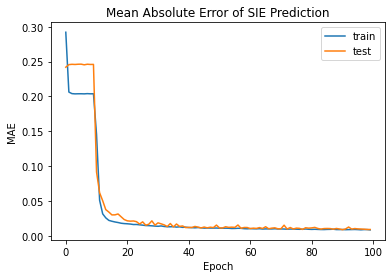

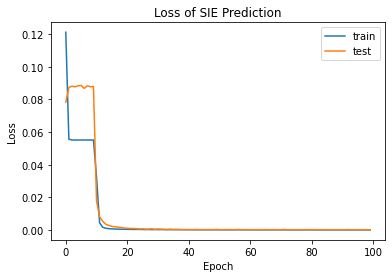

In [12]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

pred = model.predict(testX)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, 13] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, 13]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

C:\Users\FAHAD\AppData\Local\Temp/ipykernel_31716/1830956279.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, 13]


In [14]:
print(len(predictions['actual']))

1826


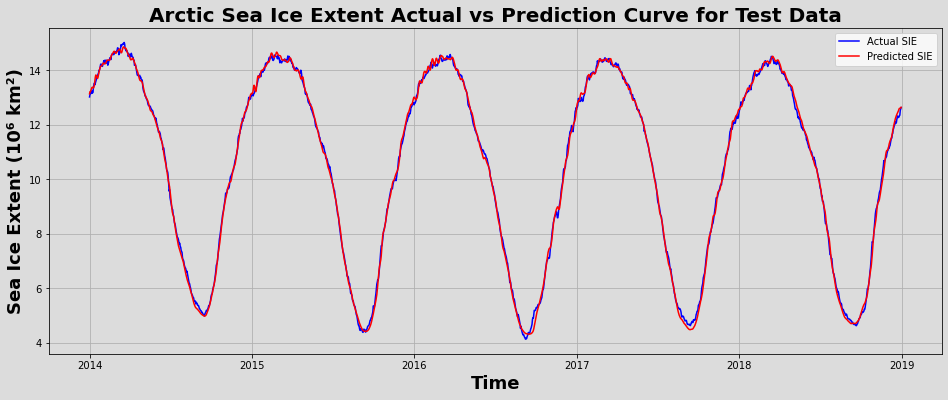

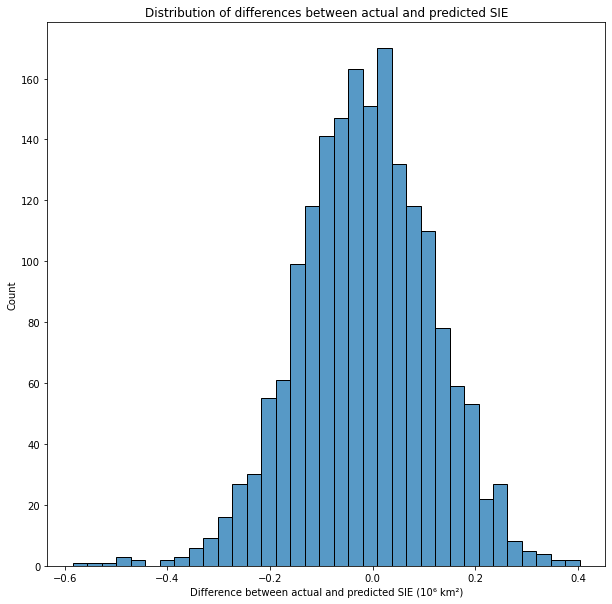

MSE :  0.017129292017838568 (10⁶ km²)
MSPE : 0.03007265023836856 %
RMSE :  0.13087892121284683 (10⁶ km²)
RMSPE : 1.7341467711346858 %
MAE :  0.10342817019768638 (10⁶ km²)
MAPE :  1.2206685633898595 %
R2 :  0.9985262446567338


In [15]:
plt.figure(figsize = (16,6), facecolor = '#dcdcdc')
ax = plt.axes()
ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 18,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 18,fontweight = "bold")
plt.plot(predictions['actual'], 'blue', label='Actual SIE')
plt.plot(predictions['predicted'], 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))